In [331]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
from dateutil import parser

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost import XGBClassifier
from xgboost import plot_importance

In [332]:
customer_retention = pd.read_csv("/Users/agowda/Downloads/Customer_Retention/customer_retention.csv")

In [333]:
print("Shape of the Data:{}".format(customer_retention.shape))

Shape of the Data:(3078, 10)


In [361]:
print("Check any missing Values")
customer_retention.isnull().any()

Check any missing Values


Start Date                     False
End Date                       False
Employer ID                    False
Employer City                  False
Employer State                 False
Number of Slots                False
Price Paid                     False
Marketplace Value Delivered    False
Applications                   False
Renewed?                       False
price_paid                     False
market_value_delivered         False
number_of_application          False
contract_length_days           False
price_per_application          False
value_addition                 False
application_per_day            False
value_addition_per_day         False
city_sparse_reduced            False
state_sparse_reduced           False
city_na                        False
city_New York                  False
city_San Francisco             False
city_Chicago                   False
city_Los Angeles               False
city_Atlanta                   False
city_Toronto                   False
c

In [335]:
print("Check Data Type:")
customer_retention.dtypes

Check Data Type:


Start Date                     object
End Date                       object
Employer ID                     int64
Employer City                  object
Employer State                 object
Number of Slots                 int64
Price Paid                     object
Marketplace Value Delivered    object
Applications                   object
Renewed?                        int64
dtype: object

## Before we start answering questions, let's try to get all the columns in consumable numeric format. 

### Helper Functions

In [336]:
def length_contract(contract):
    """
    for each row of a contract, return difference between days of End Date and Start Date
    """
    return (parser.parse(contract['End Date']) - parser.parse(contract['Start Date'])).days

### Feature Engineering

In [345]:
# Remove "$" and "," from currency values like "Price Paid" and "Marketplace Value Delivered" and convert them to float
customer_retention['price_paid'] = customer_retention['Price Paid'].apply(lambda x:float(x.replace(',','').replace("$","")))
customer_retention['market_value_delivered'] = customer_retention['Marketplace Value Delivered'].apply(lambda x:float(x.replace(',','').replace("$","")))


# Remove "," from "Application and convert to float
customer_retention['number_of_application'] = customer_retention['Applications'].apply(lambda x:float(x.replace(',','')))

# Get contract time lenght for each contract
customer_retention['contract_length_days'] = customer_retention.apply(lambda x: length_contract(x), axis=1)

#Incase there were any errors, clean up the values to reflect 1 as minimum contract time. 
#Note : Assuming data quality is high. Given more time, data cleaning could be significant here
customer_retention['contract_length_days'][customer_retention['contract_length_days']<1]=1


# Intuitive Feature Engineering 
customer_retention['price_per_application'] = customer_retention['price_paid'] / customer_retention['number_of_application']
customer_retention['value_addition'] = customer_retention['market_value_delivered']-customer_retention['price_paid']
customer_retention['application_per_day'] = customer_retention['number_of_application']/customer_retention['contract_length_days']
customer_retention['value_addition_per_day'] = customer_retention['value_addition']/customer_retention['contract_length_days']

/Users/agowda/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Price Paid Distribution


Text(0.5,1,u'Price Paid Distribution')

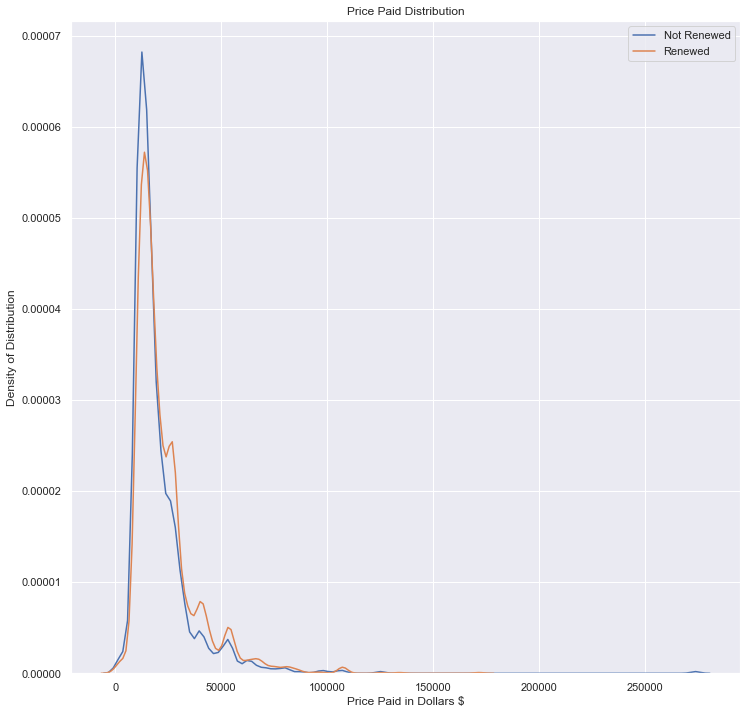

In [338]:
fig, ax = plt.subplots(figsize=(12,12))
sns.kdeplot((customer_retention['price_paid'][customer_retention['Renewed?']==0]), label = "Not Renewed", ax=ax)
sns.kdeplot((customer_retention['price_paid'][customer_retention['Renewed?']==1]), label = "Renewed", ax=ax)
plt.xlabel('Price Paid in Dollars $')
plt.ylabel('Density of Distribution')
plt.title('Price Paid Distribution')

Text(0.5,1,u'Price Paid Boxplot')

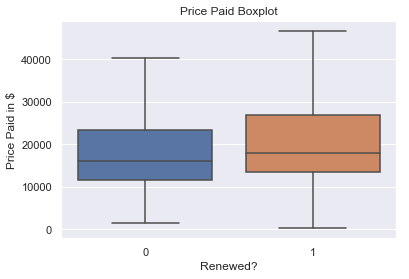

In [339]:
sns.boxplot(x='Renewed?',y='price_paid',data=customer_retention, showfliers=False)
plt.xlabel('Renewed?')
plt.ylabel('Price Paid in $')
plt.title('Price Paid Boxplot')

# Package Popularity

Text(0.5,1,u'Package Size Distribution')

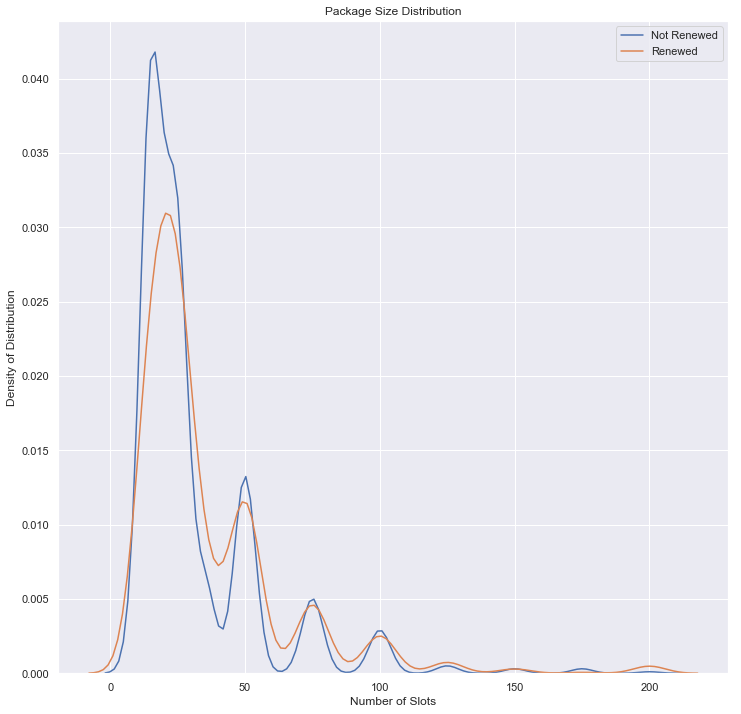

In [340]:
fig, ax = plt.subplots(figsize=(12,12))
sns.kdeplot((customer_retention['Number of Slots'][customer_retention['Renewed?']==0]), label = "Not Renewed", ax=ax)
sns.kdeplot((customer_retention['Number of Slots'][customer_retention['Renewed?']==1]), label = "Renewed", ax=ax)
plt.xlabel('Number of Slots')
plt.ylabel('Density of Distribution')
plt.title('Package Size Distribution')

In [341]:
customer_retention['Number of Slots'].value_counts()

25     891
15     873
50     489
20     226
35     213
75     195
100    108
125     28
10      22
200     16
150     12
175      5
Name: Number of Slots, dtype: int64

# Contract Time Distribution

Text(0.5,1,u'Contract Length Distribution')

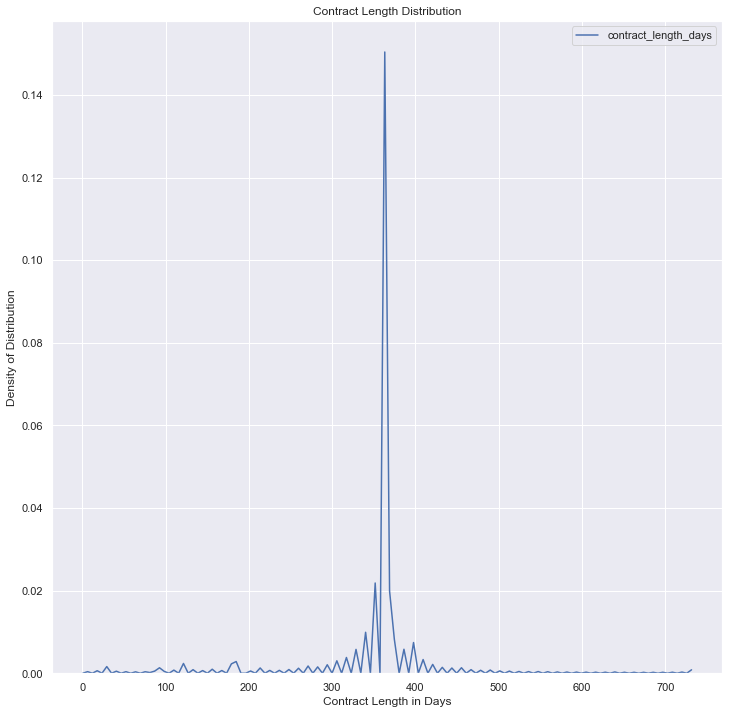

In [343]:
fig, ax = plt.subplots(figsize=(12,12))
sns.kdeplot((customer_retention['contract_length_days']))
plt.xlabel('Contract Length in Days')
plt.ylabel('Density of Distribution')
plt.title('Contract Length Distribution')

### May need to smoothen this Graph for better representation

# Metrics to Measure Performace: Relationship between Cost, Applications, Value

## Difference Between Price Paid and Market Value Delivered

Text(0.5,1,u'Value addition Distribution')

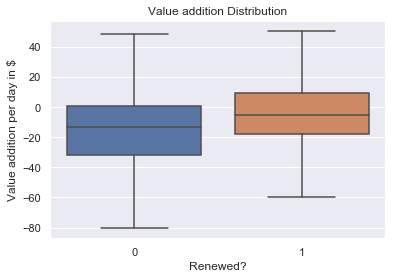

In [346]:
sns.boxplot(x='Renewed?',y='value_addition_per_day',data=customer_retention, showfliers=False)
plt.xlabel('Renewed?')
plt.ylabel('Value addition per day in $')
plt.title('Value addition Distribution')

## Price Per Application

Text(0.5,1,u'Price Paid Distribution')

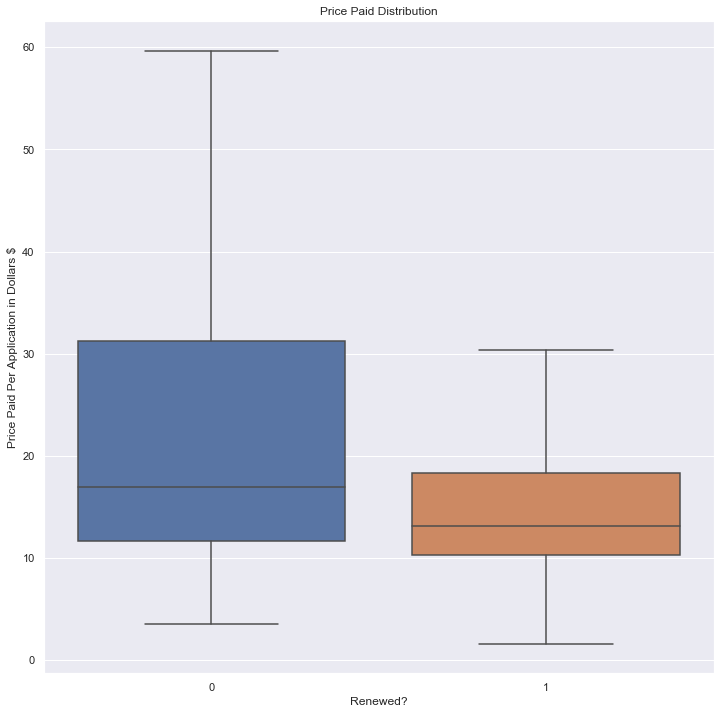

In [347]:
fig, ax = plt.subplots(figsize=(12,12))
sns.boxplot(x='Renewed?',y='price_per_application',data=customer_retention, showfliers=False)
plt.xlabel('Renewed?')
plt.ylabel('Price Paid Per Application in Dollars $')
plt.title('Price Paid Distribution')



## Market Value Delivered vs Price Paid

Text(0.5,1,u'ScatterPlot of Number of Application and Market Value Delivered')

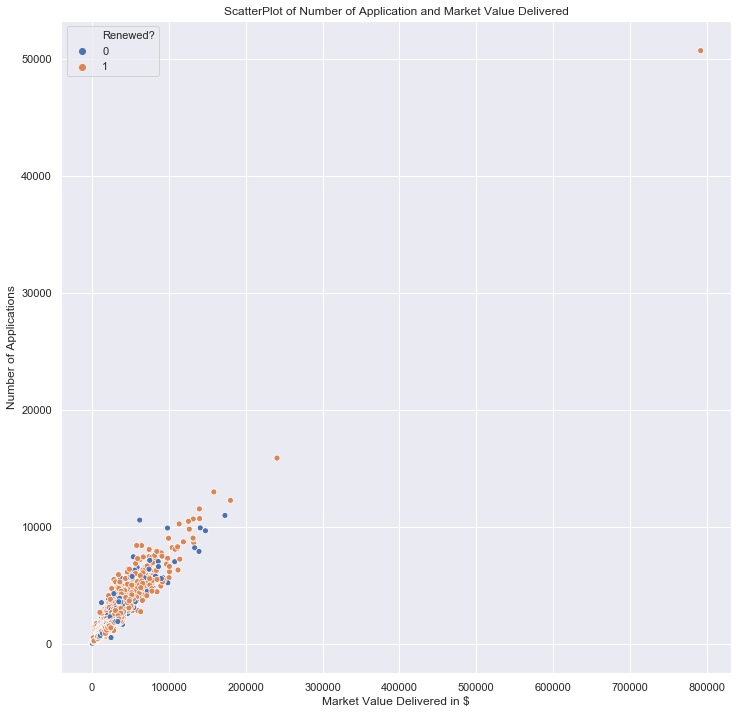

In [348]:
fig, ax = plt.subplots(figsize=(12,12))
sns.scatterplot(x='market_value_delivered', y='number_of_application', hue='Renewed?', ax=ax, data = customer_retention)
plt.xlabel('Market Value Delivered in $')
plt.ylabel('Number of Applications')
plt.title('ScatterPlot of Number of Application and Market Value Delivered')

Text(0.5,1,u'ScatterPlot of Number of Application and Price Paid')

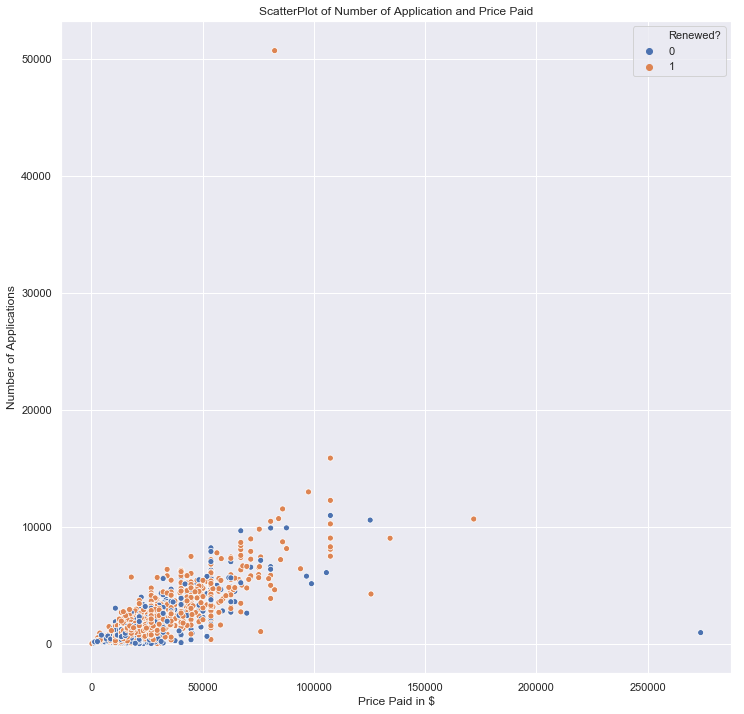

In [349]:
fig, ax = plt.subplots(figsize=(12,12))
sns.scatterplot(x='price_paid', y='number_of_application',hue='Renewed?',ax=ax, data = customer_retention)
plt.xlabel('Price Paid in $')
plt.ylabel('Number of Applications')
plt.title('ScatterPlot of Number of Application and Price Paid')

# Geography Categorical Data Handling
### City column and State Column are extremely sparse categorical Values, which would be very difficult for the ML algorithm to handle on such a small dataset. In the interest of time, I decided to take the top 8 values of city, state as categorical values and the rest(sparse set as 'other')

In [350]:
top_city = customer_retention['Employer City'].value_counts().head(8).index.tolist() + ['other']
customer_retention['city_sparse_reduced'] = pd.Categorical(customer_retention['Employer City'],categories=top_city).fillna('other')

In [351]:
customer_retention['city_sparse_reduced'].value_counts()

other            1939
na                834
New York           92
San Francisco      49
Chicago            41
Los Angeles        37
Atlanta            32
Seattle            27
Toronto            27
Name: city_sparse_reduced, dtype: int64

In [352]:
top_state = customer_retention['Employer State'].value_counts().head(8).index.tolist() + ['other']
customer_retention['state_sparse_reduced'] = pd.Categorical(customer_retention['Employer State'],categories=top_state).fillna('other')

In [353]:
customer_retention['state_sparse_reduced'].value_counts()

other             1226
na                 834
California         366
New York State     152
Florida            146
Texas              130
Illinois            85
Massachusetts       70
Pennsylvania        69
Name: state_sparse_reduced, dtype: int64

In [354]:
city_one_hot_encode = pd.get_dummies(customer_retention['city_sparse_reduced'], prefix='city')
state_one_hot_encode = pd.get_dummies(customer_retention['state_sparse_reduced'], prefix='state')
customer_retention = pd.concat([customer_retention, city_one_hot_encode, state_one_hot_encode],axis=1)

# Retention Analysis

In [396]:
print("Distribution of Renewed Contracts to Not Renewed contracts")
customer_retention['Renewed?'].value_counts()


Distribution of Renewed Contracts to Not Renewed contracts


1    2087
0     991
Name: Renewed?, dtype: int64

## Create Factors, drop all the columns with high correlation with feature engineering

In [421]:
X = customer_retention.drop(['Start Date',
                             'End Date',
                             'Employer ID',
                             'Employer City',
                             'city_sparse_reduced',
                             'state_sparse_reduced',
                             'Employer State',
                             'Price Paid',
                             'Marketplace Value Delivered',
                             'Applications',
                             'Renewed?',
                             'market_value_delivered'],
                           axis = 1)
y = customer_retention['Renewed?'] 
y = y[np.isfinite(X).all(1)]
X = X[np.isfinite(X).all(1)]

customer_retention['number_of_application']>200


"""
Condition of Outliers; not complete
"""
y = y[X['number_of_application']>200]
X = X[X['number_of_application']>200]



## Split into Test and Train datasets in 20:80 ratio


In [422]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42,stratify=y)


## Fit it with GradientBoostingClassifier, XGboost, Logistic Regression


In [423]:
gb = GradientBoostingClassifier(n_estimators=30,learning_rate=0.3)
gb.fit(X_train,y_train)
y_gb_pred = gb.predict(X_test)
print(classification_report(y_test,y_gb_pred, target_names=["Not Renewed","Renewed"]))

             precision    recall  f1-score   support

Not Renewed       0.60      0.22      0.32       174
    Renewed       0.74      0.94      0.83       408

avg / total       0.70      0.72      0.68       582



In [424]:
X_train.shape

(2326, 26)

In [425]:
np.unique(y_gb_pred, return_counts=True)

(array([0, 1]), array([ 63, 519]))

In [426]:
np.unique(y_test, return_counts=True)

(array([0, 1]), array([174, 408]))

In [427]:
XGB_model = XGBClassifier()
XGB_model.fit(X_train,y_train)
y_xgb_pred = XGB_model.predict(X_test)
print(classification_report(y_test,y_xgb_pred, target_names=["Not Renewed","Renewed"]))

             precision    recall  f1-score   support

Not Renewed       0.54      0.15      0.23       174
    Renewed       0.72      0.95      0.82       408

avg / total       0.67      0.71      0.64       582



/Users/agowda/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [428]:
XGB_model.feature_importances_

array([0.0779661 , 0.08813559, 0.09661017, 0.1220339 , 0.11694916,
       0.13728814, 0.10338983, 0.13728814, 0.00677966, 0.00338983,
       0.        , 0.01694915, 0.00508475, 0.00847458, 0.00677966,
       0.02033898, 0.00169492, 0.        , 0.00169492, 0.        ,
       0.00338983, 0.        , 0.01186441, 0.02372881, 0.        ,
       0.01016949], dtype=float32)

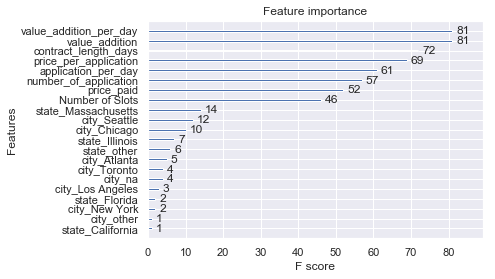

In [429]:
plot_importance(XGB_model)

In [430]:
scaler = StandardScaler()
X_train_preprocessed_std = scaler.fit_transform(X_train)
X_test_preprocessed_std = scaler.fit_transform(X_test)
lr_std = LogisticRegression(class_weight="balanced")
lr_std.fit(X_train_preprocessed_std,y_train)
y_lr_pred = lr_std.predict(X_test_preprocessed_std)
print(classification_report(y_test,y_lr_pred, target_names=["Not Renewed","Renewed"]))

             precision    recall  f1-score   support

Not Renewed       0.38      0.36      0.37       174
    Renewed       0.73      0.75      0.74       408

avg / total       0.63      0.63      0.63       582



## Compare AUC of these models
## Derive Feature Importance

In [431]:

def add_roc_curve(y_pred, model_name, y_test=y_test, plt=plt):
    fpr, tpr, thres = roc_curve(y_test, y_pred)
    auc = round(roc_auc_score(y_test, y_pred),2)
    plt.plot(1-fpr,tpr,label="{model_name}, auc={auc}".format(model_name=model_name,auc=auc))
    plt.legend(loc=0)
    return(plt)

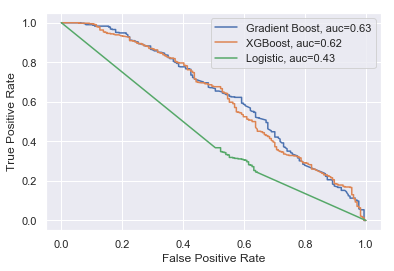

In [432]:
gb_plt = add_roc_curve(pd.DataFrame(gb.predict_proba(X_test))[1], y_test= y_test, model_name="Gradient Boost")
xgb_plt = add_roc_curve(pd.DataFrame(XGB_model.predict_proba(X_test))[1], y_test= y_test, model_name="XGBoost")
lr_plt = add_roc_curve(pd.DataFrame(lr_std.predict_proba(X_test))[1], y_test= y_test, model_name="Logistic")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# Value addition per day Optimization Oppurtunity

Text(0.5,1,u'Distribution of Value Addition per day')

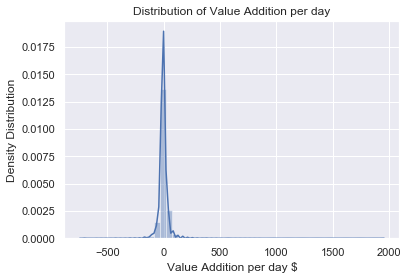

In [433]:
sns.distplot(customer_retention["value_addition_per_day"][customer_retention['number_of_application']>200])
plt.xlabel('Value Addition per day $')
plt.ylabel('Density Distribution')
plt.title('Distribution of Value Addition per day')

In [420]:
(customer_retention['number_of_application']>200).sum()

2908

In [419]:
len(customer_retention['number_of_application'])

3078